# Data inspection and preprocessing - 3, Preprocessing EMG
Code is meant to be **read**! Respect [PEP 8](https://peps.python.org/pep-0008/)!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal
import scipy.interpolate

In [2]:
emg_data = np.loadtxt(open("data\\EMG.csv", "rb"), delimiter=",", skiprows=True)
finger_states = np.loadtxt(open("data\\Kinematics.csv", "rb"), delimiter=",", skiprows=True)

emg_tstamps = emg_data[:, 0]
finger_states_tstamps = finger_states[:, 0]

In [3]:
unique_finger_states = np.unique(finger_states[:, 1:], axis=0)
unique_finger_states

array([[0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 1. ],
       [0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 1. , 1. , 1. ],
       [0. , 1. , 1. , 1. , 1. , 1. ],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [1. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 1. , 1. , 0. , 0. , 0. ],
       [1. , 1. , 1. , 1. , 0. , 0. ],
       [1. , 1. , 1. , 1. , 1. , 1. ]])

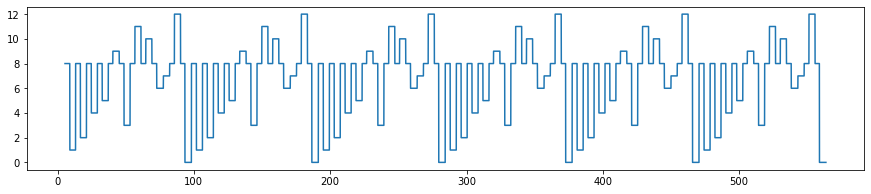

In [4]:
n_labels = unique_finger_states.shape[0]
labels = np.zeros(finger_states.shape[0])
for i in range(n_labels):
    sel = np.where((finger_states[:, 1:] == unique_finger_states[i, :]).all(axis=1))
    labels[sel] = i
    
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(finger_states_tstamps, labels)

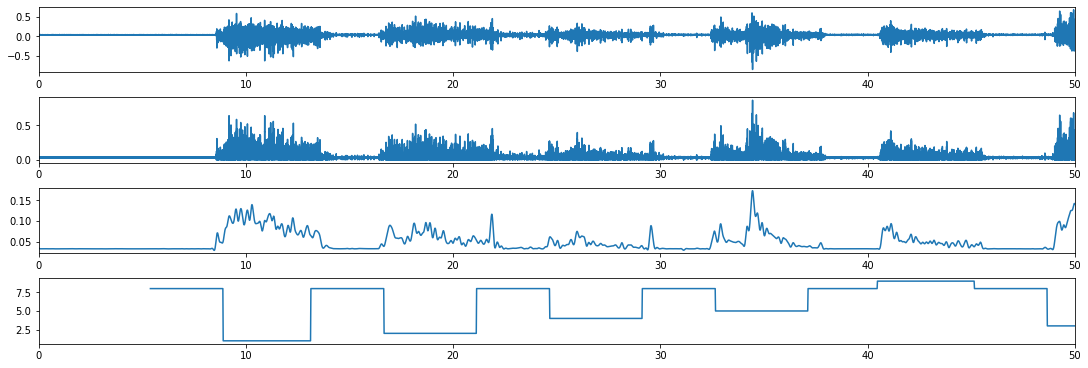

In [5]:
fs_emg = 2000  # sampling frequency (given) [Hz]
filter_order = 4
lp_cutoff = 5  # low-pass filter cut-off [Hz]

n_samples_to_display = 100000
emg_tstamps_to_display = np.linspace(0, n_samples_to_display / fs_emg, n_samples_to_display)

b, a = scipy.signal.butter(N=filter_order, Wn=lp_cutoff, fs=fs_emg, btype='lowpass')

n_channels = emg_data.shape[1] - 1
emg_rectified = np.zeros_like(emg_data[:, 1:])
emg_filt = np.zeros_like(emg_data[:, 1:])
for i in range(n_channels):
    emg_rectified[:, i] = np.abs(emg_data[:, i])
    emg_filt[:, i] = scipy.signal.filtfilt(b, a, emg_rectified[:, i])

fs_finger_states = 60  # sampling frequency (given) [Hz]
n_samples_finger_states = int(n_samples_to_display / fs_emg * fs_finger_states)
finger_states_tstamps_to_display = np.linspace(0, n_samples_finger_states / fs_finger_states, n_samples_finger_states)

fig, ax = plt.subplots(4, 1, figsize=(15, 5), constrained_layout=True)
ax[0].plot(emg_tstamps_to_display, emg_data[:n_samples_to_display, 1])
ax[1].plot(emg_tstamps_to_display, emg_rectified[:n_samples_to_display, 1])
ax[2].plot(emg_tstamps_to_display, emg_filt[:n_samples_to_display, 1])
ax[3].plot(finger_states[:n_samples_finger_states, 0], labels[:n_samples_finger_states])

for i in range(4):
    ax[i].set_xlim([0, 50])

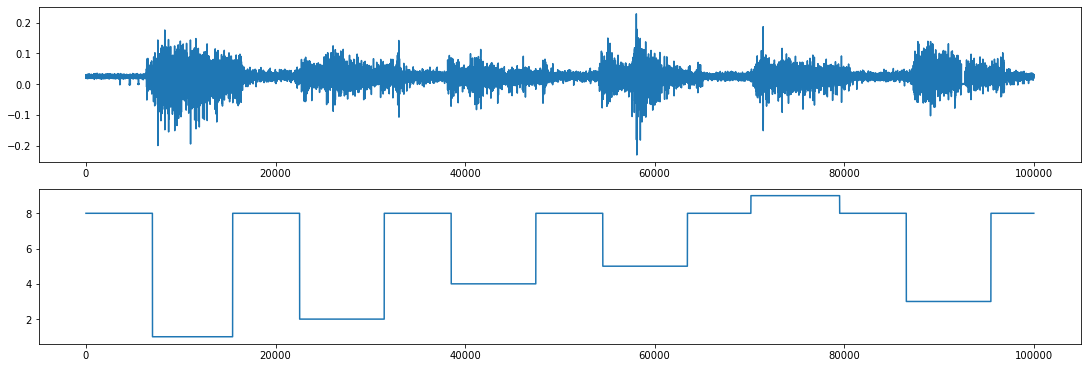

In [6]:
# upsample finger_states, align signals
fs = np.max([fs_emg, fs_finger_states])
start_time = np.max([np.min(emg_tstamps), np.min(finger_states_tstamps)])
end_time = np.min([np.max(emg_tstamps), np.max(finger_states_tstamps)])

common_time = np.arange(start=start_time, stop=end_time, step=1 / fs)

interpolant = scipy.interpolate.interp1d(
    x=finger_states_tstamps,
    y=labels,
    kind="nearest",
    fill_value="extrapolate",
    axis=0
)
labels_aligned = interpolant(common_time)

interpolant = scipy.interpolate.interp1d(
    x=emg_tstamps,
    y=emg_data[:, 1:],
    kind="nearest",
    fill_value="extrapolate",
    axis=0
)
emg_aligned = interpolant(common_time)

fig, ax = plt.subplots(2, 1, figsize=(15, 5), constrained_layout=True)
ax[0].plot(emg_aligned[:n_samples_to_display, 1])
ax[1].plot(labels_aligned[:n_samples_to_display])

In [7]:
window_length = 200  # [ms]
window_overlap = 100  # [ms]

n_samples = emg_aligned.shape[0]

window_length_samples = int(window_length / 1000 * fs)
window_spacing_samples = int((window_length - window_overlap) / 1000 * fs)

n_windows = int(np.floor((n_samples - window_length_samples) / window_spacing_samples) + 1)
emg_windows = np.zeros((n_windows, window_length_samples, n_channels))
labels = np.zeros(n_windows)
for i in range(n_windows):
    emg_windows[i, :, :] = emg_aligned[(window_spacing_samples * i):(window_spacing_samples * i + window_length_samples), :]
    labels[i] = labels_aligned[window_spacing_samples * i + window_length_samples - 1]

In [8]:
print(emg_windows.shape)
print(labels.shape)

(5581, 400, 6)
(5581,)
